# **Analysis and Prediction of Sentinel-2 image time series dynamics**

The goal of this project is to design learning algorithms to understand, visualize,  learn and predict the dynamics of reflectance values in Sentinel-2 images, and to design tools to visualize their dynamics efficiently.

There are two sites of interest, located in the forests of Fontainebleau and Orléans. See Google Maps for high resolution RGB data over Fontainebleau:

https://goo.gl/maps/EFrtjU6p2WgWh4ww9

The first task is data visualizationa and analysis. Indeedn the dataset is large and hard to analyse fully as is. Dimensionality reduction can be helpful for several tasks:
- It allows to summarize the information in the data in a reduced number of variables
- It can be used to compress the data, or to reduce the computation time for expensive tasks
- It helps interpreting the data by providing "modes" that capture general patterns which are representative of the whole data behavior

The second task is to train machine learning models able to predict the future of the time series on the short or the long run.

# Import packages

In [ ]:
import torch

import numpy as np
import random as rd
import matplotlib.pyplot as plt

# Import data

The data is publicly available on this Google Drive folder: https://drive.google.com/drive/folders/1doHnjryCMptkzxYFfw-ILwAD0tOK3LGH?usp=sharing

One way to get it is to simply download it from there, possibly put it on your own drive and then upload it in your Colab session.

Alternatively, you can directly transfer the files from the folder to this session using the "gdown" command, as shown below:

In [ ]:
# Fontainebleau interpolated time series

!gdown 1ZWH06EQYTiBUHRABVH2o_s2I_9Zm6dpo -O Fontainebleau_interpolated.npy

Downloading...
From: https://drive.google.com/uc?id=1ZWH06EQYTiBUHRABVH2o_s2I_9Zm6dpo
To: /content/Fontainebleau_interpolated.npy
100% 3.43G/3.43G [00:42<00:00, 80.9MB/s]


In [ ]:
# We rescale the data to values between 0 and 1
data = np.load('Fontainebleau_interpolated.npy')
max_Fontainebleau = np.max(data)
data /= max_Fontainebleau # divide by maximum value to get data in reflectance

In [ ]:
# data_test = np.load('Orléans_interpolated.npy')
# max_Orleans = np.max(data_test)
# data_test /= max_Orleans # data in reflectance

In [ ]:
print(data.shape)
#343 -> temporal index ; 10 -> spectral band index ; 500, 500 -> spatial indexes

(343, 10, 500, 500)


In [ ]:
# This code snippet is just there to get the right format to display dates on the x-axis when plotting time series

from datetime import date, timedelta
import matplotlib.dates as mdates

date_zero = date.fromisoformat('2018-02-25')
print(date_zero)

five_days = timedelta(days=5)

dates = [date_zero]
for date in range(data.shape[0]-1) :
  dates.append(dates[-1] + five_days)
print(dates)

2018-02-25
[datetime.date(2018, 2, 25), datetime.date(2018, 3, 2), datetime.date(2018, 3, 7), datetime.date(2018, 3, 12), datetime.date(2018, 3, 17), datetime.date(2018, 3, 22), datetime.date(2018, 3, 27), datetime.date(2018, 4, 1), datetime.date(2018, 4, 6), datetime.date(2018, 4, 11), datetime.date(2018, 4, 16), datetime.date(2018, 4, 21), datetime.date(2018, 4, 26), datetime.date(2018, 5, 1), datetime.date(2018, 5, 6), datetime.date(2018, 5, 11), datetime.date(2018, 5, 16), datetime.date(2018, 5, 21), datetime.date(2018, 5, 26), datetime.date(2018, 5, 31), datetime.date(2018, 6, 5), datetime.date(2018, 6, 10), datetime.date(2018, 6, 15), datetime.date(2018, 6, 20), datetime.date(2018, 6, 25), datetime.date(2018, 6, 30), datetime.date(2018, 7, 5), datetime.date(2018, 7, 10), datetime.date(2018, 7, 15), datetime.date(2018, 7, 20), datetime.date(2018, 7, 25), datetime.date(2018, 7, 30), datetime.date(2018, 8, 4), datetime.date(2018, 8, 9), datetime.date(2018, 8, 14), datetime.date(2018

# Visualise the time series for one single pixel

Pixel: (321, 334)
Spectral band: 0


Text(0.5, 0, 'date')

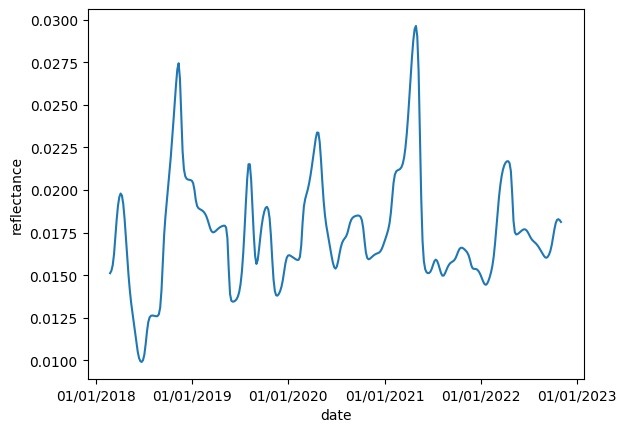

In [ ]:
#Visualise the temporal evolution of one random spectral band from one random pixel
random_pixel = (rd.randint(0, data.shape[2]-1), rd.randint(0, data.shape[3]-1))
band = rd.randint(0, data.shape[1]-1)

print(f"Pixel: {random_pixel}")
print(f"Spectral band: {band}")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.plot(dates, data[:,band,random_pixel[0], random_pixel[1]])
plt.ylabel('reflectance')
plt.xlabel('date')

Pixel: (361, 438)


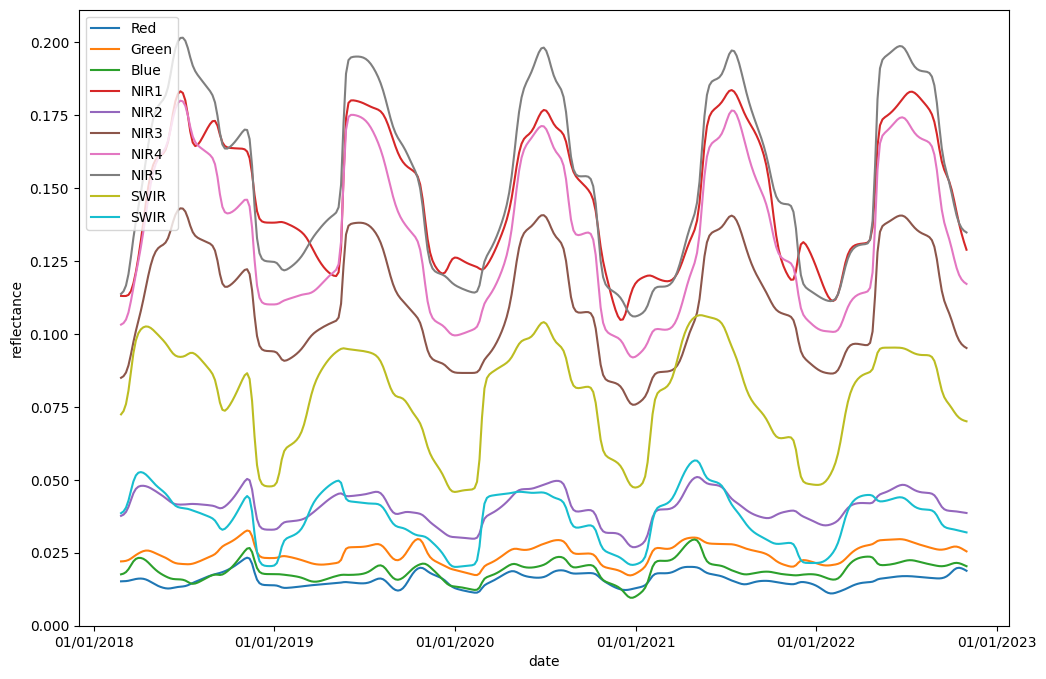

In [ ]:
# Visualise the temporal evolution of all spectral bands from a random pixel
random_pixel = (rd.randint(0, data.shape[2]-1), rd.randint(0, data.shape[3]-1))
print(f"Pixel: {random_pixel}")
plt.figure(figsize=(12,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.plot(dates, data[:,:,random_pixel[0], random_pixel[1]])
plt.ylabel('reflectance')
plt.xlabel('date')
plt.legend(['Red', 'Green', 'Blue', 'NIR1', 'NIR2', 'NIR3', 'NIR4', 'NIR5', 'SWIR', 'SWIR']) # Those are the different spectral bands, in the order with this data form. More info on the spectral bands used here: https://gisgeography.com/sentinel-2-bands-combinations/


# Visualise the whole images

Shape of data_viz : (343, 500, 500, 3)


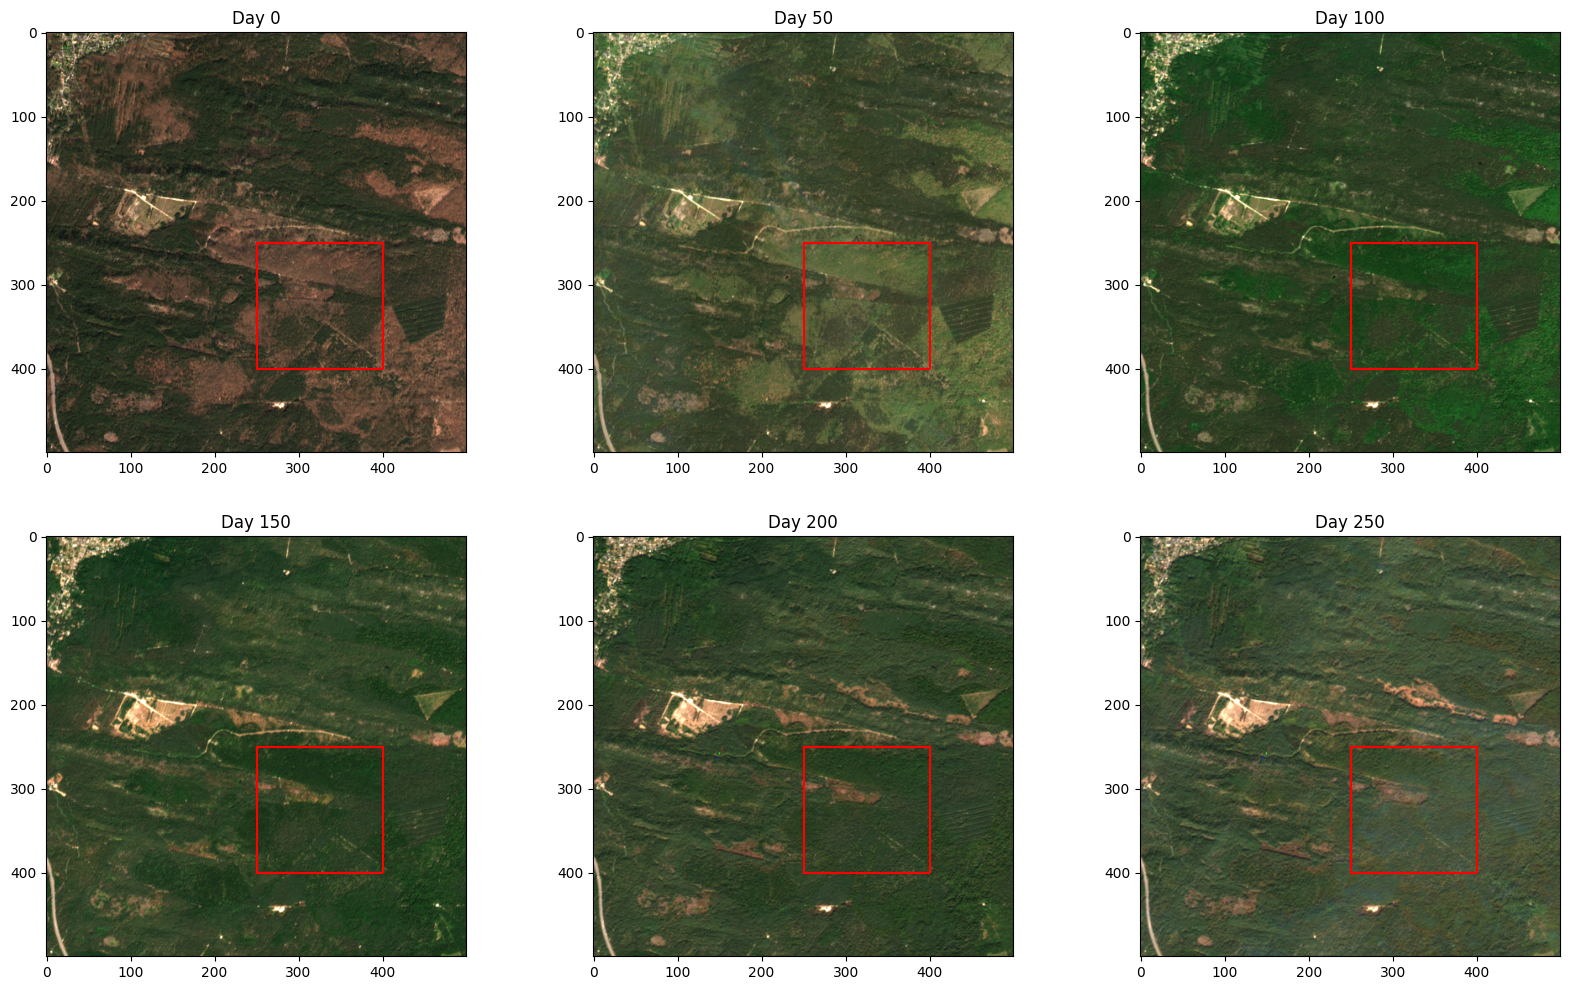

In [ ]:
# Fontainebleau images
data_viz = data[:,[2,1,0],:,:].transpose((0,2,3,1))
print(f"Shape of data_viz : {data_viz.shape}")

times = [0,10,20,30,40,50]

plt.figure(figsize=(20,12))

for i in range(len(times)):
  plt.subplot(2,3,i + 1 )
  plt.imshow(data_viz[times[i]]*10) # 10 for visualisation purposes
  plt.title(f'Day {times[i]*5}') # 1 sample every 5 days
  plt.plot(np.arange(250,400),250*np.ones(150),'r')
  plt.plot(np.arange(250,400),400*np.ones(150),'r')
  plt.plot(250*np.ones(150),np.arange(250,400),'r')
  plt.plot(400*np.ones(150),np.arange(250,400),'r')

In [ ]:
# # Orléans images
# data_viz_test = data_test[:,[2,1,0],:,:].transpose((0,2,3,1))
# print(f"Shape of data_viz : {data_viz.shape}")

# times = [0,10,20,30,40,50]

# plt.figure(figsize=(20,12))

# for i in range(len(times)):

#   plt.subplot(2,3,i + 1 )
#   plt.imshow(data_viz_test[times[i]]*10) # 10 for visualisation purposes
#   plt.title(f'Day {times[i]*5}') # 1 sample every 5 days


**Smaller crop of interest on Fontainebleau**

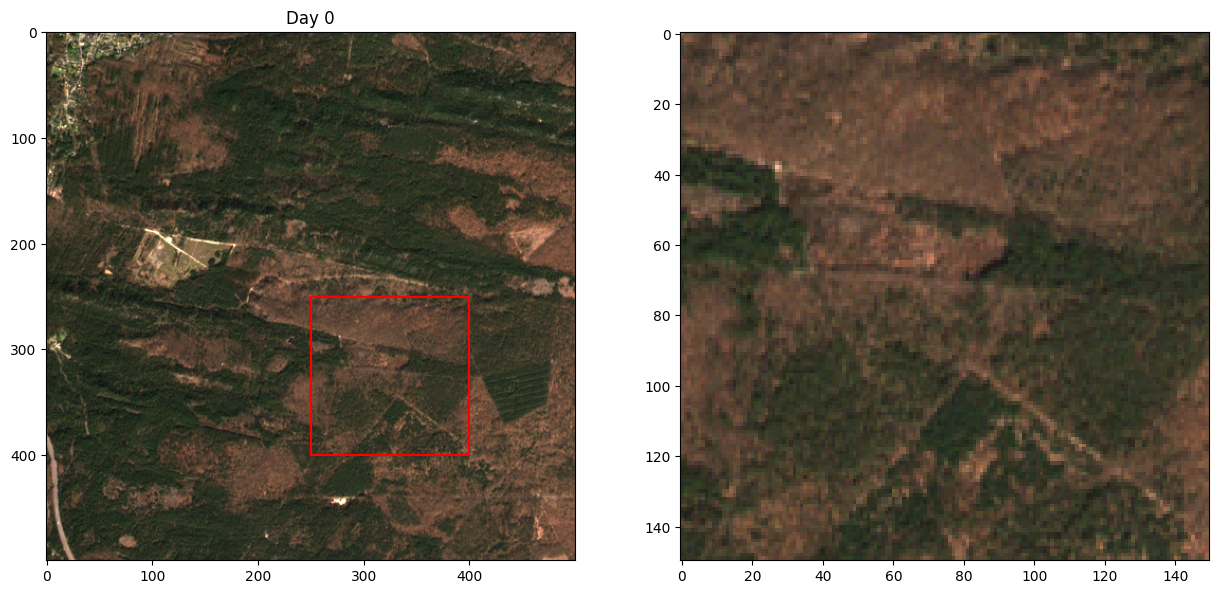

In [ ]:
data_crop = data[:,:,250:400,250:400] # we use a smaller crop to simplify the problem and to reduce the computational burden

T,L,m,n = data_crop.shape

plt.figure(figsize =(15,7.5))
plt.subplot(121)
plt.imshow(data_viz[times[0]]*10)
plt.title(f'Day {times[0]*5}')
plt.plot(np.arange(250,400),250*np.ones(150),'r')
plt.plot(np.arange(250,400),400*np.ones(150),'r')
plt.plot(250*np.ones(150),np.arange(250,400),'r')
plt.plot(400*np.ones(150),np.arange(250,400),'r')

data_crop_viz = data_crop[:,[2,1,0],:,:].transpose((0,2,3,1))

plt.subplot(122)
plt.imshow(data_crop_viz[times[0]]*10)

# First task: Dimension Reduction and data visualization

The goal of this task is to compute a reduced representation of the dataset, useful for visualization and summarization purposes.

This can be done by either a PCA (principal componenent analysis) or an autoencoder.

The data is a 4-way array $X \in \mathbb{R}^{T \times L \times m \times n}$ where $T$ is the number of time steps, $L$ is the number of spectral bands, and $m$ and $n$ are the spatial dimensions of the image.

One first simple way to reduce the dimensionality, if we are interested in vegetation (as is the case here) using the Normalized Difference Vegetation Index (NDVI), which is sensitive to the presence of vegetation. It is defined as

\begin{equation}
NDVI = \frac{NIR - RED}{NIR + RED}
\end{equation}

where NIR is the Near Infrared band (4th band) and RED is the red band (3rd) band of the multispectral data. It is sensitive to the presence of vegetation growth in a pixel. An pixel with dense and healthy vegetation will have an NDVI close to 1. NDVI values less than 0 suggest a lack of dry land. Water will have an NDVI close to -1.

# Principal Component Analysis (PCA) on NDVI (univariate time series of images) or on the full dataset (multivariate time series of images)

One first analysis techniques that can be performed for data understanding and visualisation is Principal Component Analysis (PCA), also called Empirical Orthogonal Functions (EOF). The goal is to identify a set of variables, called components, that are orthogonal to one another and best explain the dataset in a particular sense (i.e. the projection of the data on the subspace spanned by any number of these components in order maximizes the variance for projections on subspaces of this dimension). PCA applies to a dataset $\mathbf{X} \in \mathbb{R}^{P\times N}$, where $P$ is the number of variables, and $N$ is the number of samples. PCA finds orthogonal components $u_k \in \mathbb{R}^{P}, k = 1,...P$ and coefficients $a_{kn}$ such that
\begin{equation*}
\mathbf{x}_n = \sum_{k=1}^P a_{kn} \mathbf{u}_k
\end{equation*}
with $\mathbf{u}_k^T \mathbf{u}_l = 0$ for $k\neq l$, and $||\mathbf{u}_k|| = 1$.
The $\mathbf{u}_k$ form an orthonormal basis. So, PCA is a change of basis. The first two or three components can be used for data visualisation, since it is the most faithful representation of the data that we can get in a 2D or 3D linear subspace. For a complete reference on PCA, see the book by Christopher Bishop, *Pattern Recognition and Machine Learning*, chapter 12: https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/


The dataset can then be approximated by a weighted sum of the different components, for a given number of components $K$:

\begin{equation*}
\mathbf{x}_n \approx \sum_{k=1}^K a_{kn} \mathbf{u}_k
\end{equation*}

The easiest way to compute principal component analysis is to use the scikit-learn package (sklearn) for python. See documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

The algorithm is based on the eigendecomposition of the covariance matrix of the dataset, whose eigenvectors are the principal components. The coefficients are obtained by orthoghonal projection of the data on the obtained basis. The eigenvalues give the variance associated to each component. Computing the percentage of total variance explained by $K$ components is a way to assess the quality of the approximation.

The question is, what do you want to consider as variables and what do you want to consider as samples in your dataset?

In [1]:
import sklearn
from sklearn.decomposition import PCA



#  Autoencoder for nonlinear dimension reduction/unmixing

Another way to explain the data/reduce the dimensionality is to use deep autoencoders. They are used to find a reduced representation of the data with a small number of variables. The technique applies to data $\mathbf{X} \in \mathbb{R}^{P\times N}$, where $P$ is the number of input variables, and $N$ is the number of samples, just like PCA. The difference with PCA is that autoencoders are nonlinear! For an input $\mathbf{x} \in \mathbb{R}^{P}$, the quantity $\phi(\mathbf{x}) = \mathbf{z}\in \mathbb{R}^{K}$ is an encoded version of $\mathbf{x}$. The network is trained so that the decoded quantity $\mathbf{x}' = \psi(\mathbf{z}) ≈ \mathbf{x}$

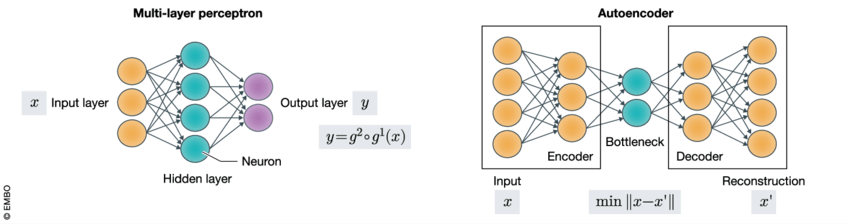


To build and train an autoencoder in pytorch, or pytorch-lightning, one needs first to build a dataset class for the data to be understood by pytorch, and a DataLoader class to be able to feed the model with batches of data.

It is always good practice to divide the dataset into at least two sets: a training set and a validation set (and possibly a test set).

Then, you can focus on creating the model, choosing a cost function to minimize, and training the model.

Here the specificity of multispectral data (well suited to decompositions as linear combinations of key components) may inspire interpretable autoencoder models. A reference on possible models is  *Palsson, B., Sveinsson, J. R., & Ulfarsson, M. O. (2022). Blind hyperspectral unmixing using autoencoders: A critical comparison. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 15, 1340-1372.*

In [ ]:
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader


# NDVI or Full multivariate time series prediction

Another problem we propose to to tackle with this dataset is to build a NN (or another type of model) that can predict the future evolution of the time series.

Here, for NN based approaches, RNNs such as LSTM are a natural choice. But there can be many more approaches, based on DL or not, that can be tested.

For simplicity, you can start with NDVI image time series, which are univariate, or tackle the whole multivariate image time series.

Again, it is best to leave out the end of the time series as validation data to find out how good the model is for short or long term predictions.